<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/GradCAM%2B%2B_Vs_GradCAM_Vs_Single_Pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Image and Trained Model

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# id = ['18A9mAt9r4CoXLeoCK2muPNvIEqVKvOaw']
id = ['1pZgspfWi1Mh8sqV_lbJLQTuFZyhnTPlA']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('localization_2.zip')
!unzip localization_2.zip

Archive:  localization_2.zip
replace localization/001202.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Fix seed to get result reproducibility

In [2]:
import random
import torch
import numpy as np
import os

def seed_everything(seed=42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

**Demo**

Grad-CAM Library

In [3]:
''' Code modified from https://github.com/jacobgil/pytorch-grad-cam
'''

! pip install ttach
import cv2
import numpy as np
import torch
import ttach as tta


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compitability with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))
    
    def save_activation(self, module, input, output):
        activation = output  
        # print(activation.size())      # torch.Size([81, 2048, 4, 7])
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())  

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        # print(grad.size())              # torch.Size([81, 2048, 4, 7])
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients
        # print(len(self.gradients))   # 1

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

class BaseCAM:
    def __init__(self,
                 model,
                 target_layers,
                 use_cuda=False,
                 reshape_transform=None,
                 compute_input_gradient=False,
                 uses_gradients=True):
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    
    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        loss = 0
        # model output is the loss
        for i in range(len(target_category)):
            # output[i, target_category[i]]: output at particular data and particular class
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth=False):
        weights = self.get_cam_weights(input_tensor, target_layer, target_category, activations, grads)  # shape of weights: (81, 2048)
        weighted_activations = weights[:, :, None, None] * activations      # shape of weighted_activations: 81, 2048, 4, 7
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)  # shape of cam: 81, 4, 7 

        return cam

    def forward(self, input_tensor, target_category=None, eigen_smooth=False, target_size=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        output = self.activations_and_grads(input_tensor)
        output_sigmoid = torch.sigmoid(output)
        # print(input_tensor.shape)       # torch.Size([81, 3, 120, 210])
        # print(output.shape)             # torch.Size([81, 7])
        if isinstance(target_category, int):        
            ## if target_category is not None, return a list of target cetegery with length of batch size
            ## eg target_category = 0 => [0,0,0,0,0,.....,0,0]  len(target_category)=batch_size
            target_category = [target_category] * input_tensor.size(0) 

        if target_category is None:
            # np.argmax = returns indices of the max element of the array in a particular axis
            # for every dataset in the batch, return the class indices of the output of the model that has the largest value 
            # eg: [ .... 0 0 0 0 0 0 0 0 0 6 6 0 2 0 0 0 0 0 0 0 0 0 ... ] (most dataset has tool 0, some are tool 6 and 2)
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
        else:
            # assert: tests if a condition is true
            assert(len(target_category) == input_tensor.size(0))

        if self.uses_gradients:
            self.model.zero_grad()
            loss = self.get_loss(output, target_category)
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   target_category,
                                                   eigen_smooth, 
                                                   target_size)
        # return self.aggregate_multi_layers(cam_per_layer)
        return output_sigmoid, self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self, input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor,
            target_category,
            eigen_smooth,
            target_size):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        if target_size == None:
            target_size = self.get_target_width_height(input_tensor)  # (w, h): (210, 120)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for target_layer, layer_activations, layer_grads in \
                zip(self.target_layers, activations_list, grads_list):
            cam = self.get_cam_image(input_tensor,          # print(cam.shape): (81, 4, 7)  cam=>numpy array
                                     target_layer,
                                     target_category,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)

            cam[cam<0.0]=0 # works like mute the min-max scale in the function of scale_cam_image  # make those <0 = 0 range[0,1.7495756]
            scaled = self.scale_cam_image(cam, target_size)  # from size (81, 4, 7) to (81, 120, 210) , value ranged from [0,1.7495756] to [0.0 0.99988055]
            cam_per_target_layer.append(scaled[:, None, :])  # (81, 1, 120, 210)  (bs,num_target_layer,h,w)
        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        # does not affect when target_layer = 1  shape: (81, 1, 120, 210)
        # if target_layer > 1: join the sequence tgt  shape: (bs, num_target_layer, h, w) 
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)  # result.shape: (81, 120, 210)
        return self.scale_cam_image(result)

    def scale_cam_image(self, cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img) 
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)   # result.shape: (81, 120, 210) (bs,h,w)
        return result

    def forward_augmentation_smoothing(self,
                                       input_tensor,
                                       target_category=None,
                                       eigen_smooth=False):
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               target_category, eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor,
                 target_category=None,
                 aug_smooth=False,
                 eigen_smooth=False,
                 target_size=None):
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, target_category, eigen_smooth, target_size)

        return self.forward(input_tensor,
                            target_category, eigen_smooth, target_size)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)
    
    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):     
        return np.mean(grads, axis=(2, 3))  # shape of grads: 81,2048,4,7



class GradCAMPlusPlus(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(GradCAMPlusPlus, self).__init__(model, target_layers, use_cuda,
                                              reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads**2
        grads_power_3 = grads_power_2 * grads
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(2, 3))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, :, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=(2, 3))
        return weights        #  (1, 2048)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extract feature from heatmap

In [4]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

def heatmap_extract_feature(cam, pred_cls, input_tensor, feature_outputs, threshold, feature_path_bbox, feature_path_frame, pool_size): 
    ''' extract features from feature map based on gradcam heatmap
        save the features by (1) bbox and (2) frame
        input: args, CAM object, prediction from model [1, num_class], feature maps [layer2, layer3, layer4],
                bbox_threshold, path to save bbox features, path to save frame features, adaptive average pooling size
    '''
    
    feature_map = feature_outputs[1]        # [1] => layer 3: [1,1024,16,20]
    feature_map_c = feature_map.shape[1]    # 1024
    feature_map_h = feature_map.shape[2]    # 16
    feature_map_w = feature_map.shape[3]    # 20

    frame_features = []
    heatmap_all = []
    for cls in range (11):
        if pred_cls[cls]:
            output, heat_map = cam(input_tensor=input_tensor, target_category=cls, target_size=(feature_map_w,feature_map_h))  #grayscale_cam: (bs,H,W)
            heatmap_all.append(heat_map)
            heat_map = torch.from_numpy(heat_map)       # [1,16,20] 
          
            heat_map = heat_map.expand(feature_map_c,1,feature_map_h,feature_map_w)     # torch.Size([1024, 1, 16, 20])
           
            # heat_map.shape = torch.Size([1024, 1, 16, 20])
            # heat_map[:,0].shape = torch.Size([1024, 16, 20])
            # feature_map.shape = torch.Size([1, 1024, 16, 20]
            
            ## ref: https://github.com/mobarakol/tutorial_notebooks/blob/main/heatmap_to_bbox.ipynb
            #### v1: feature map as obj feature
            feature_map_cls = feature_map[heat_map[None,:,0]>threshold]                             # feature_map_cls[None,None] = torch.Size([1, 1, 94208]) <= example
          
            att = F.adaptive_avg_pool1d(feature_map_cls[None,None],[pool_size[0]]).permute(2,0,1)   # torch.Size([128,1,1])
            att = F.adaptive_avg_pool2d(att[None],[pool_size[1],pool_size[2]]).permute(0, 1, 2, 3)  # torch.Size([1, 128, 2, 2])
            att = torch.flatten(att)                                                                # torch.Size([512])

            # feature_name = feature_path_bbox + '_{}_{}_{},{},{},{}'.format(cls, 0, 0, 0, 320, 256)
            # print(feature_name)
            # # np.savez_compressed(feature_name, feat=att.data.cpu().float().numpy())
            frame_features.append(att.data.cpu().float().numpy())

        else:
            continue 

    frame_features = np.array(frame_features) 
    print('Features shape: ', frame_features.shape)       # (num_pred_cls, feature_size) 
    # # np.save(feature_path_frame, frame_features)
    return output, np.array(heatmap_all), frame_features

Model 

In [5]:
import copy
import torch.nn as nn

class resnet_50(nn.Module):
    '''
    Model for feature extraction
    input: model
    output: feature map at layer2, 3 and 4

    references: 
    - https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b
    - https://forums.fast.ai/t/pytorch-best-way-to-get-at-intermediate-layers-in-vgg-and-resnet/5707/2

    #### feature map size: (for image size of 256,320)
    # layer 1 [:-5]: torch.Size([1, 256, 64, 80])
    # layer 2 [:-4]: torch.Size([1, 512, 32, 40])
    # layer 3 [:-3]: torch.Size([1, 1024, 16, 20])
    # layer 4 [:-2]: torch.Size([1, 2048, 8, 10])

    #### alternative method:
    # self.features = nn.Sequential(*list(model.children())[:-4])
    # def forward(self, x):
    #     x = self.features(x)
    #     return x
    '''
    
    def __init__(self, model):
        super(resnet_50, self).__init__()
        self.children_list = []
        self.children_list_2 = []
        self.children_list_3 = []
        self.children_list_4 = []
        self.model = model
        
        for n,c in self.model.named_children():
            self.children_list.append(c)
            if n == 'layer2':
                self.children_list_2 = copy.deepcopy(self.children_list)
            elif n == 'layer3':
                self.children_list_3 = copy.deepcopy(self.children_list)
            elif n == 'layer4':
                self.children_list_4 = copy.deepcopy(self.children_list)
        self.net2 = nn.Sequential(*self.children_list_2)
        self.net3 = nn.Sequential(*self.children_list_3)
        self.net4 = nn.Sequential(*self.children_list_4)
        
    def forward(self, x):
        x2 = self.net2(x)
        x3 = self.net3(x)
        x4 = self.net4(x)
        return [x2,x3,x4]

Load model checkpoint

In [26]:
import torch.nn as nn
from torch.nn import DataParallel
from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint      = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval();

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GradCAM and GradCAM++

In [7]:
# GradCAM: gradcam_type = 0
# GradCAM++: gradcam_type = 1

def extract_feature(gradcam_type, model, score, input, heatmap_thr):
  model.eval()
  target_layers = [model.layer4[-1]] 

  # Construct the CAM object once, and then re-use it on many images:
  if gradcam_type == 0:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
  elif gradcam_type == 1:
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)
  else:
    print('Invalid GradCAM type')
  feature_model = resnet_50(model)

  '''---------------------------- Extracting Region Features ------------------------------------'''
  current_frame_path_bbox = 'model_d_bbox'
  current_frame_path_frame = 'model_d_frame'

  pool_size = [512,1,1]

  feature_outputs = feature_model(inputs[None].cuda())        
  output, heatmap_all, frame_features = heatmap_extract_feature(cam, score, inputs[None].cuda(), feature_outputs, heatmap_thr, current_frame_path_bbox, current_frame_path_frame, pool_size)
  return output, heatmap_all

Load Image and Heatmap Visualization

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


prediction of model: [1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
predicted class: ['bipolar_forceps', 'monopolar_curved_scissors', 'suction', 'tissue']
Features shape:  (4, 512)
Features shape:  (4, 512)
output(GradCAM Model): tensor([[9.9945e-01, 3.2975e-01, 1.5531e-02, 8.7310e-01, 2.4157e-03, 9.9615e-01,
         6.1521e-03, 5.4203e-02, 1.1096e-05, 4.6702e-05, 9.9998e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
output(ResNet50) [9.9944526e-01 3.2975122e-01 1.5531374e-02 8.7310445e-01 2.4157292e-03
 9.9615294e-01 6.1521116e-03 5.4203004e-02 1.1095928e-05 4.6701687e-05
 9.9998415e-01]
max and min of heatmap: 0.9999999 0.0


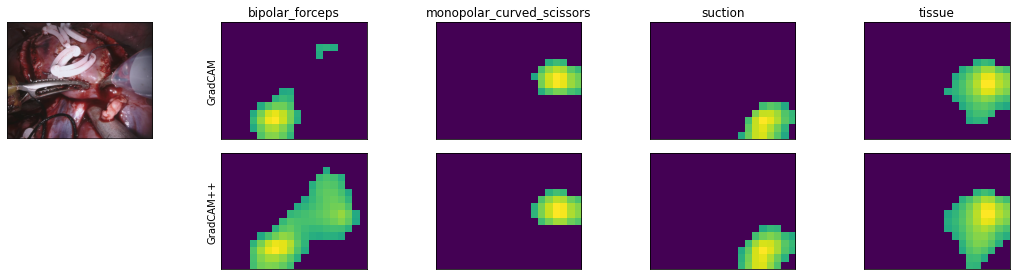

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt

image_name = "localization/1_frame146.png"
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])
inputs = transforms(image).cuda()


'''------------------------------- Model Prediction ------------------------------------'''
pred_thr = 0.5
heatmap_thr = 0.6
outputs_tool = model.forward(inputs[None])
pred = torch.sigmoid(outputs_tool[0]).detach().cpu().numpy()
score = np.array(pred>pred_thr, dtype=float)
print('prediction of model:',score)

indices = [i for i, x in enumerate(score) if x == 1]
pred_class = []
for i in range(len(indices)):
  pred_class.append(classes[indices[i]])
print('predicted class:', pred_class)

'''---------------------------- Heatmap Visualization ---------------------------------'''
output, heatmap_gradcam = extract_feature(0, model, score, inputs, heatmap_thr)
output_pluspls, heatmap_plusplus = extract_feature(1, model, score, inputs, heatmap_thr)

print('============================')
print('output(GradCAM Model):', output)
print('output(ResNet50)', pred)
print('============================')
print('max and min of heatmap:',heatmap_gradcam.max(), heatmap_gradcam.min())
heatmap_gradcam[heatmap_gradcam<heatmap_thr] = 0
heatmap_plusplus[heatmap_plusplus<heatmap_thr] = 0
img = Image.open(image_name)

x = len(heatmap_gradcam) + 1

figure = plt.figure(figsize=(15, 4))
figure.add_subplot(2,x,1)
plt.axis("off")
plt.imshow(img)
for j in range(1,x):
    figure.add_subplot(2,x,j+1)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap_gradcam[j-1][0])
    if j == 1:
      plt.ylabel('GradCAM')
    plt.title(pred_class[j-1])
for k in range(1,x):
    figure.add_subplot(2,x,x+k+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap_plusplus[k-1][0])
    if k == 1:
      plt.ylabel('GradCAM++')
plt.subplots_adjust(wspace=0.06, 
                    hspace=0)
figure.tight_layout()
plt.show()

# Single Pass GradCAM

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get th

Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
Labels: [0, 3, 5, 10] Predictions: [0, 3, 5, 10]
min max tensor(0.) tensor(1.)
min max tensor(0.) tensor(1.)
min max tensor(0.) tensor(1.)
min max tensor(0.) tensor(1.)


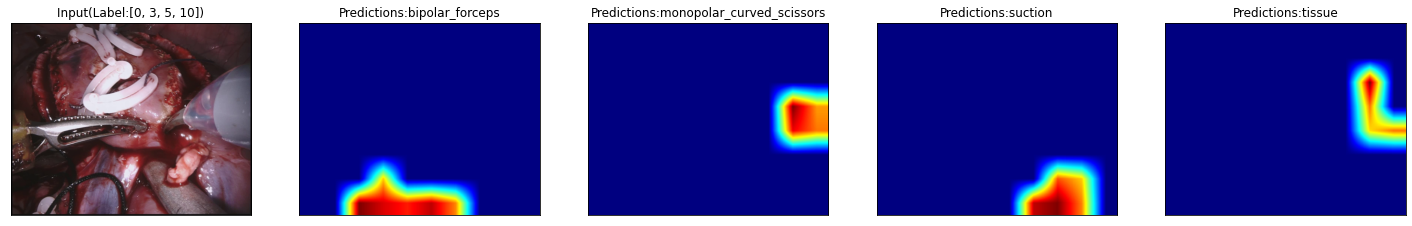

In [42]:
import torch.nn as nn
from torch.nn import DataParallel
from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3
    last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)


def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out = model(img).cpu()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        print('min max', heatmap.min(), heatmap.max())
        hmap = heatmap.numpy()
        hmap[hmap<0.65] = 0
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))
